## ToDo List
- [x] Checar se formato de datas conferem.
- [x] Remover UGs sem liberação OC
- [x] Considerar coluna montagem. Onde estiver vazio, pegar valor de Torres para EOL, no skate.
- [x] Calcular tempos de construção por marco: (IO_realizado - realizado), (CC_realizado - realizado) ...etc  (ordem:IO,CC,ME,OT)
- [x] Calcular atraso da operação comercial (realizado - outorgado)
- [x] Calcular média e std do tempo de construção.
- [x] Calcular data dos marcos medios (outorgado - tempo_medio_de_construcao) por fonte.
- [x] Calcular atrasos com base nos marcos medios
- [x] Calcular media e std dos atrasos. 
- [x] Normalizar os atrasos calculados (atraso - atraso_medio)/std
- [x] Construir matriz de correlação de Pearson
- [x] Calcular os coeficientes para regressão linear
- [x] Para UHE pegar todas UGs, para as demais pegar a primeira UG apenas
- [ ] Separar um cojunto aleatório para teste
- [ ] Comparar pegando primeira UG e media por grupo
- [ ] Separar curvas para ACR e ACL


In [1]:
import pandas as pd
import numpy as np
import re
import pyodbc
from pprint import pprint
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations

In [2]:
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

#### Transforma coluna IdeUsinaOutorga das UHEs para que cada UG possua esse campo diferente. Por exemplo as UGs da usina 12 serão 12_0, 12_1...

In [3]:
bd_combined = pd.read_parquet("bd_combined.gzip")

In [4]:
bd_combined.index.name = "idx"
bd_combined.IdeUsinaOutorga = bd_combined.IdeUsinaOutorga.astype(str)
mask_UHE_duplicate = (bd_combined.SigTipoGeracao == "UHE") & (bd_combined.IdeUsinaOutorga.duplicated(keep=False))
bd_combined.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] = bd_combined.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] +"_"+ bd_combined.loc[mask_UHE_duplicate].groupby("IdeUsinaOutorga").cumcount().astype(str)
bd_combined.sample(15)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,DatConcretagemRealizado,DatMontagemOutorgado,DatMontagemRealizado,Torres_Outorga,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,,,,
2255,35713,2017-01-06,2017-01-14,2017-01-25,2017-02-01,PA,2.4,2016-10-18,2016-11-15,NaT,NaT,2016-11-17,2016-12-05,None,None,NaT,NaT,2016-12-07,2016-12-05,UTE,5,2.4,bdworgs,None
3799,37075,2023-12-01,2024-01-01,2020-10-10,2020-12-15,RN,72765.0,2023-04-01,2019-11-15,2023-05-01,2020-08-15,2023-06-01,2020-08-03,None,None,NaT,NaT,2023-05-01,2019-07-15,EOL,7,24255.0,skate,2019-02-11
3510,35229,2020-12-10,2020-12-30,2020-10-16,2020-11-21,BA,31185.0,2019-08-01,2019-11-15,2019-12-02,2020-05-06,2020-04-03,2020-08-10,None,None,NaT,NaT,2019-09-20,2019-09-20,EOL,1,3465.0,skate,2019-06-25
4194,38107,2023-01-20,2023-07-31,NaT,NaT,PI,45600.0,2022-03-15,NaT,2022-06-11,NaT,2022-10-10,NaT,None,None,NaT,NaT,2022-09-21,2022-03-24,EOL,8,45600.0,skate,2021-11-23
5967,55914,2022-04-24,2022-05-01,NaT,NaT,RJ,258640.0,2022-02-16,2022-04-04,NaT,NaT,2022-03-30,NaT,None,None,NaT,NaT,2022-02-16,2022-04-04,UTE,1,255000.0,skate,2021-11-05
1763,31813,2016-12-01,2017-01-01,2016-05-26,2016-07-27,CE,21.0,2015-12-01,2015-07-15,2016-03-01,2015-08-10,2016-07-01,NaT,2016-07-01,2016-01-15,NaT,NaT,2015-08-01,2015-05-21,EOL,7,21.0,bdworgs,None
1163,30691,2013-12-26,2014-01-01,2014-06-26,2014-08-20,CE,29.7,NaT,2013-04-01,NaT,2013-05-01,NaT,2014-03-20,None,2014-03-20,NaT,NaT,NaT,2012-06-01,EOL,11,29.7,bdworgs,None
3133,33864,2022-04-25,2022-05-09,NaT,NaT,RN,16800.0,2020-09-08,2021-06-15,2020-10-15,NaT,2021-09-27,NaT,None,None,NaT,NaT,2020-10-05,2021-06-18,EOL,3,12600.0,skate,2020-02-11
132,27910,NaT,2002-09-30,2010-03-02,2010-03-10,MG,19.8,2001-03-01,2007-02-01,NaT,NaT,2002-05-03,NaT,None,None,NaT,2009-07-22,NaT,NaT,PCH,2,19.8,bdworgs,None


#### Remove linhas cujas colunas DatUGInicioOpComerOutorgado e DatLiberOpComerRealizado não sejam nulas

In [5]:
mask_OC_notna = bd_combined.DatUGInicioOpComerOutorgado.notna() & bd_combined.DatLiberOpComerRealizado.notna()
bd_combined = bd_combined[mask_OC_notna].copy(deep=True)

#### Cria dicionário com o tempo de cada marco a até a DatLiberOpComerRealizado por cada UG

In [6]:
dict_fase_marco = {
    "IO_OC" : "DatInicioObraRealizado",
    "CC_OC" : "DatConcretagemRealizado",
    "ME_OC" : "DatMontagemRealizado",
    "OT_OC" : "DatLiberacaoSFGTeste"
}

dict_marco_nome = {v: k for k, v in dict_fase_marco.items()}

#### Calcula o tempo por fase por UG

In [7]:
lst_infos = ["IdeUsinaOutorga","SigTipoGeracao","origem"]

tempo_fase_por_UG = bd_combined[lst_infos].copy(deep=True) #[["IdeUsinaOutorga","SigTipoGeracao","origem"]]
for nome,marco in dict_fase_marco.items():
    tempo_fase_por_UG[nome] = bd_combined["DatLiberOpComerRealizado"]-  bd_combined[marco]

tempo_fase_por_UG["Atraso"]  =  bd_combined["DatLiberOpComerRealizado"]-  bd_combined["DatUGInicioOpComerOutorgado"]
#tempo_fase_por_UG = pd.concat([tempo_fase_por_UG,bd_combined[list(dict_fase_marco.values()) + ["DatUGInicioOpComerOutorgado","DatLiberOpComerRealizado"]]],axis=1)
tempo_fase_por_UG.head(25)

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12_0,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,bdworgs,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,bdworgs,1553 days,NaT,NaT,11 days,0 days
5,42_2,UHE,bdworgs,1615 days,NaT,NaT,24 days,0 days
6,127,UTE,bdworgs,561 days,NaT,NaT,NaT,15 days
7,161,PCH,bdworgs,1163 days,677 days,NaT,38 days,2290 days
9,291,PCH,bdworgs,697 days,419 days,NaT,45 days,1676 days


#### Remove incosistências e gera tabela com motivos para eliminação

In [8]:
is_first = True 
combinacoes = list(combinations([x for x in dict_fase_marco.keys() ],2))
motivo_eliminacao = tempo_fase_por_UG[["SigTipoGeracao","origem","IdeUsinaOutorga"]].copy(deep=True)
motivo_eliminacao["motivo_eliminacao"] = ""

for p_marco, s_marco in combinacoes:
    mask_ordem_correta_parcial =  ((tempo_fase_por_UG[p_marco] >= tempo_fase_por_UG[s_marco]) | 
                 tempo_fase_por_UG[p_marco].isna() | 
                 tempo_fase_por_UG[s_marco].isna())
    
    motivo_eliminacao.loc[~mask_ordem_correta_parcial,"motivo_eliminacao"] += f"{s_marco[:-3]}>{p_marco[:-3]},"
    mask_ordem_correta = mask_ordem_correta_parcial if is_first else (mask_ordem_correta & mask_ordem_correta_parcial)
    is_first = False 
motivo_eliminacao =motivo_eliminacao[~mask_ordem_correta]
tempo_fase_por_UG_filtered = tempo_fase_por_UG[mask_ordem_correta].copy(deep=True)
tempo_fase_por_UG_filtered

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12_0,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,bdworgs,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,bdworgs,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...,...
5763,50872,UTE,skate,98 days,NaT,98 days,41 days,-920 days
5787,51444,UTE,skate,99 days,NaT,99 days,22 days,-385 days
5793,51450,UTE,skate,104 days,NaT,104 days,26 days,-380 days


#### Gera tabelas de marcos e fases com apenas as primeiras UGs que entraram em OC. 

In [9]:
idx_primeira_ug =  bd_combined[mask_ordem_correta].groupby(["IdeUsinaOutorga"],sort=False).DatLiberOpComerRealizado.idxmin()
# Considera apenas a primeira UG a entrar em OC
bd_combined_usinas =   bd_combined.loc[idx_primeira_ug,:]
tempo_construcao_por_usina = tempo_fase_por_UG_filtered.loc[idx_primeira_ug,:]
tempo_construcao_por_usina

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12_0,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,bdworgs,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,bdworgs,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...,...
5763,50872,UTE,skate,98 days,NaT,98 days,41 days,-920 days
5787,51444,UTE,skate,99 days,NaT,99 days,22 days,-385 days
5793,51450,UTE,skate,104 days,NaT,104 days,26 days,-380 days


####  

#### Calcula outliers e tempo medio por fase e geracao já desconsiderando outliers

In [26]:
is_first = True
th_norm = 1.65
tipos_geracao = bd_combined.SigTipoGeracao.unique()
dict_tempo_fase_mean_std = {}
for i,SigTipoGeracao in enumerate(tipos_geracao):
    dict_tempo_fase_mean_std[SigTipoGeracao] = {}
    for nome_coluna in dict_fase_marco.keys():
        m = tempo_construcao_por_usina.loc[(tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao),nome_coluna].mean()
        std = tempo_construcao_por_usina.loc[(tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao),nome_coluna].std()
        th = (th_norm*std)+m
        outliers = ((tempo_construcao_por_usina[nome_coluna]) > th)| ((tempo_construcao_por_usina[nome_coluna]) < -th)
        dict_tempo_fase_mean_std[SigTipoGeracao][f"{nome_coluna}_media"] = tempo_construcao_por_usina[~outliers].loc[(tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao),nome_coluna].mean()
        dict_tempo_fase_mean_std[SigTipoGeracao][f"{nome_coluna}_std"] = tempo_construcao_por_usina[~outliers].loc[(tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao),nome_coluna].std()
pd.DataFrame(dict_tempo_fase_mean_std)

In [33]:
marco_medio_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao"]]
def id_marco(ID,fase,marco):
    geracao = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"SigTipoGeracao"].values[0]
    #tempo_medio = tempo_construcao_por_geracao.loc[geracao,f"{nome}_media"]
    tempo_medio = dict_tempo_fase_mean_std[geracao][f"{fase}_media"]
    data_OC = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"DatUGInicioOpComerOutorgado"].values[0]
    data_marco_medio = data_OC - tempo_medio
    return data_marco_medio


for fase,marco in dict_fase_marco.items():
    marco_medio_usina[f"{marco}_estimado"] = marco_medio_usina.IdeUsinaOutorga.apply(lambda ID :  id_marco(ID,fase,marco))

In [34]:
atraso_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao","Atraso"]]
nomes_colunas_atrasos = []
for nome,marco in dict_fase_marco.items():
    nome_coluna = f"{marco}_atraso"
    nomes_colunas_atrasos.append(nome_coluna)
    atraso_usina[nome_coluna] = bd_combined_usinas[marco] - marco_medio_usina[f"{marco}_estimado"]

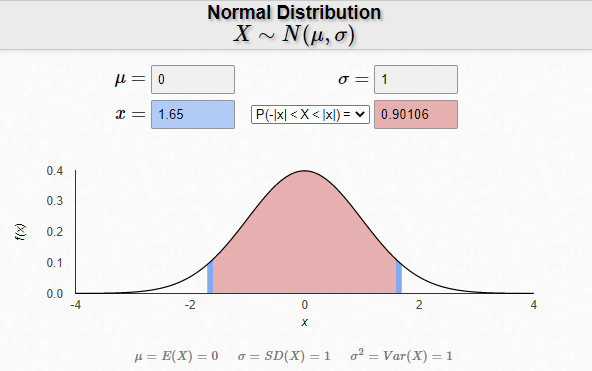

Não foi possível calcular: DatConcretagemRealizado_atraso para UTE: zero-size array to reduction operation minimum which has no identity
Não foi possível calcular: DatConcretagemRealizado_atraso para UFV: zero-size array to reduction operation minimum which has no identity


,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
UHE,74.7%,72.9%,38.9%,99.9%
UTE,88.0%,-,90.1%,99.8%
PCH,97.5%,98.3%,99.0%,100.0%
CGH,69.4%,92.7%,95.4%,99.9%
EOL,92.9%,93.8%,96.4%,99.9%
UFV,93.9%,-,94.2%,99.6%


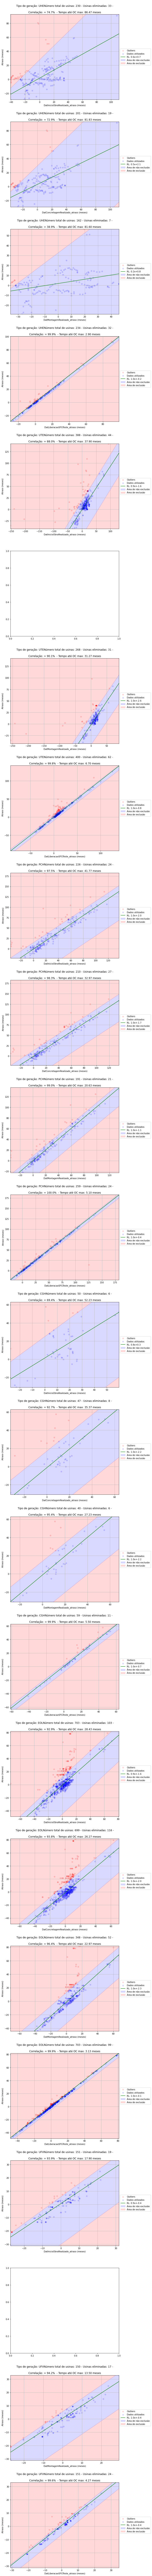

In [41]:
plot_created = False
analises_origem =["Ambos"]     #["skate","bdworgs","Ambos"]

matrix_pearson = {}
matrix_pearson_out = {}

def calc_regression(x,y):
    res = stats.linregress(x.flatten(), y.flatten())
    a, b, r, p_value, std_err = res    
    return [a, b, r, p_value, std_err]


def extract_xy(df : pd.DataFrame, x_name : str , y_name : str, order_by : str):
    idx_notna = (df[x_name].notna()) &  (df[y_name].notna())
    ordered_notna = df[idx_notna].sort_values(by = order_by)
    x = ordered_notna[x_name]
    y = ordered_notna[y_name]
    try:
        x = x.dt.days.to_numpy()
        y = y.dt.days.to_numpy()
    except:
        pass
    xy = np.zeros((2,x.shape[0]))
    xy[0] = x
    xy[1] = y
    return xy
    


th_nornm = 2
   
num_subplots = (len(tipos_geracao))*(len(nomes_colunas_atrasos))
fig, axes = plt.subplots(num_subplots,1,figsize=(10,num_subplots*7))
plot_created =True
count = -1
for i,SigTipoGeracao in enumerate(tipos_geracao):
    matrix_pearson[SigTipoGeracao] = []
    for nome_coluna in nomes_colunas_atrasos:
        count+=1
        ax = axes[count]
        try:
            # Máscara com apenas indices que correspondem ao tipo geração especificado
            idx_geracao = atraso_usina.SigTipoGeracao == SigTipoGeracao 
            # Todos pares x,y para o tipo geracao tal que: x = Atraso y = Atraso do marco especificado
            x1,y1 =  extract_xy(atraso_usina[idx_geracao], nome_coluna, "Atraso", nome_coluna)/30
            x_plot = np.linspace(x1.min()-10,x1.max()+10,100)
            m = dict_tempo_fase_mean_std[SigTipoGeracao][f"{dict_marco_nome[nome_coluna[:-7]]}_media"]
            std = dict_tempo_fase_mean_std[SigTipoGeracao][f"{dict_marco_nome[nome_coluna[:-7]]}_std"]
            th = (th_norm*std)+m
            outliers = ((tempo_construcao_por_usina[dict_marco_nome[nome_coluna[:-7]]]) > th)| ((tempo_construcao_por_usina[dict_marco_nome[nome_coluna[:-7]]]) < -th)
            x2,y2 = extract_xy(atraso_usina[idx_geracao & outliers], nome_coluna, "Atraso", nome_coluna)/30
            x3,y3 = extract_xy(atraso_usina[idx_geracao & ~outliers], nome_coluna, "Atraso", nome_coluna)/30

            a, b, r, p_value, std_err = calc_regression(x3,y3)
            r_str = f"{100*r:.1f}%"

            # Converte para meses
            th = th.days/30
            m = m.days/30
            std = std.days/30

            # Plota resultados
            ax.scatter(x2,y2,color="red",alpha=0.15,label="Outliers")
            ax.scatter(x3,y3,color="blue",alpha=0.15,label="Dados utilizados")
            ax.plot(x_plot,a*x_plot+b+1,color="green",label= f"RL: {a:.1f}x+{b:.1f}")
            ax.set_title(f"""\nTipo de geração: {SigTipoGeracao}Número total de usinas: {x1.shape[0]} - Usinas eliminadas: {x2.shape[0]} -\n\nCorrelação: = {r_str}  - Tempo até OC max: {th:.2f} meses""")
            ax.grid()
            #ax.plot(x_plot,x_plot-m,linewidth=2)
            ax.fill_between(x_plot,x_plot-th-m,x_plot+th-m,color="blue",alpha=0.15,label="Área de não exclusão")
            ax.fill_between(x_plot,x_plot-th-m,y1.min(),color="red",alpha=0.15,label="Área de exclusão")
            ax.fill_between(x_plot,x_plot+th-m,y1.max(),color="red",alpha=0.15)
            ax.set_xlim(x1.min(),x1.max())
            ax.set_ylim(y1.min(),y1.max())
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax.set_xlabel(f"{nome_coluna} (meses)")
            ax.set_ylabel(f"Atraso (meses)")
            matrix_pearson[SigTipoGeracao].append(r_str)
        except (ValueError,AttributeError) as error:
            print(rf"Não foi possível calcular: {nome_coluna} para {SigTipoGeracao}: {error}")
            matrix_pearson[SigTipoGeracao].append("-")
                
matrix_pearson =  pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)
display(matrix_pearson.T)
plt.tight_layout()
plt.savefig("calculos_atrasos.pdf")
person_matrix = pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)